## Access Vessel Xbt Realtime Nonqc (Parquet)

This Jupyter notebook demonstrates how to access and plot vessel xbt realtime nonqc data, available as a [Parquet](https://parquet.apache.org) dataset stored on S3.

🔗 More information about the dataset is available [in the AODN metadata catalogue](https://catalogue-imos.aodn.org.au/geonetwork/srv/eng/catalog.search#/metadata/35234913-aa3c-48ec-b9a4-77f822f66ef8).

📌 The source of truth for this notebook is maintained on [GitHub](https://github.com/aodn/aodn_cloud_optimised/tree/main/notebooks/vessel_xbt_realtime_nonqc.ipynb).


In [1]:
dataset_name = "vessel_xbt_realtime_nonqc"

## Install/Update packages and Load common functions

In [2]:
import os, requests, importlib.util

open('setup.py', 'w').write(requests.get('https://raw.githubusercontent.com/aodn/aodn_cloud_optimised/main/notebooks/setup.py').text)

spec = importlib.util.spec_from_file_location("setup", "setup.py")
setup = importlib.util.module_from_spec(spec)
spec.loader.exec_module(setup)

setup.install_requirements()
setup.load_dataquery()

Using CPython 3.12.6 interpreter at: /home/lbesnard/miniforge3/envs/AodnCloudOptimised/bin/python
Creating virtual environment at: .venv
Activate with: source .venv/bin/activate
Audited 240 packages in 54ms


✅ Local version 0.2.1 is up to date (remote: 0.2.1)


In [3]:
from DataQuery import GetAodn

# Understanding the Dataset

## Understanding Parquet Partitioning

Parquet files can be **partitioned** by one or more columns, which means the data is physically organised into folders based on the values in those columns. This is similar to how databases use indexes to optimise query performance.

Partitioning enables **faster filtering**: when you query data using a partitioned column, only the relevant subset of files needs to be read—improving performance significantly.

For example, if a dataset is partitioned by `"site_code"`, `"timestamp"`, and `"polygon"`, filtering on `"site_code"` allows the system to skip unrelated files entirely.

In this notebook, the `GetAodn` class includes built-in methods to efficiently filter data by **time** and **latitude/longitude** using the **timestamp** and **polygon** partitions. Other partitions can be used for filtering via the `scalar_filter`.

Any filtering on columns that are **not** partitioned can be significantly slower, as all files may need to be scanned. However, the `GetAodn` class provides a `scalar_filter` method that lets you apply these filters at load time—before the data is fully read—helping reduce the size of the resulting DataFrame.

Once the dataset is loaded, further filtering using Pandas is efficient and flexible.

See further below in the notebook for examples of how to filter the data effectively.

To view the actual partition columns for this dataset, run:


In [4]:
aodn = GetAodn()
dname = f'{dataset_name}.parquet'
%time aodn_dataset = aodn.get_dataset(dname)

CPU times: user 101 ms, sys: 22.4 ms, total: 123 ms
Wall time: 6.8 s


In [5]:
aodn_dataset.dataset.partitioning.schema

XBT_line: string
timestamp: int32
polygon: string

## List unique partition values

In [6]:
%%time
unique_partition_value = aodn_dataset.get_unique_partition_values('XBT_line')
print(list(unique_partition_value)[0:2])  # showing a subset only

['IX28', 'PX06']
CPU times: user 9.71 ms, sys: 2.66 ms, total: 12.4 ms
Wall time: 10.3 ms


## Visualise Spatial Extent of the dataset
This section plots the polygons representing the areas where data is available. It helps to identify and create a bounding box around the regions containing data.

/home/lbesnard/miniforge3/envs/AodnCloudOptimised/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


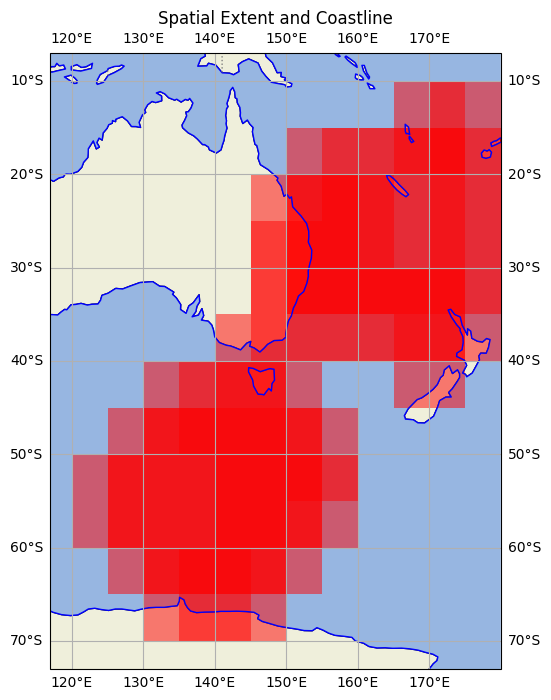

In [7]:
aodn_dataset.plot_spatial_extent()

## Get Temporal Extent of the dataset

Similary to the spatial extent, we're retrieving the minimum and maximum timestamp partition values of the dataset. This is not necessarely accurately representative of the TIME values, as the timestamp partition can be yearly/monthly... but is here to give an idea

In [8]:
aodn_dataset.get_temporal_extent()

(Timestamp('2020-09-01 13:46:59.999999744'), Timestamp('2024-06-23 18:13:00'))

## Read Metadata

For all Parquet datasets, we create a sidecar file named **_common_metadata** in the root of the dataset. This file contains both the dataset-level and variable-level attributes.  
The metadata can be retrieved below as a dictionary, and it will also be included in the pandas DataFrame when using the `get_data` method from the `GetAodn` class.

In [9]:
metadata = aodn_dataset.get_metadata()
metadata

2025-06-05 13:31:56,034 - aodn.GetAodn - INFO - Retrieving metadata for aodn-cloud-optimised/vessel_xbt_realtime_nonqc.parquet
2025-06-05 13:31:56,165 - aodn.GetAodn - WARNING - Old 'dataset_metadata' deprecated key found in parquet schema. Renamed to 'global_attributes'. Dataset should be updated


{'TIME': {'type': 'timestamp[ns]',
  'standard_name': 'time',
  'long_name': 'time',
  'axis': 'T',
  'valid_min': 0.0,
  'valid_max': 90000.0},
 'LATITUDE': {'type': 'double',
  'standard_name': 'latitude',
  'long_name': 'latitude',
  'units': 'degrees_north',
  'axis': 'Y',
  'valid_min': -90.0,
  'valid_max': 90.0,
  'reference_datum': 'WGS84 coordinate reference system'},
 'LONGITUDE': {'type': 'double',
  'standard_name': 'longitude',
  'long_name': 'longitude',
  'units': 'degrees_east',
  'axis': 'X',
  'valid_min': -180.0,
  'valid_max': 180.0,
  'reference_datum': 'WGS84 coordinate reference system'},
 'DEPTH': {'type': 'double',
  'axis': 'Z',
  'long_name': 'depth',
  'positive': 'down',
  'reference_datum': 'sea surface',
  'standard_name': 'depth',
  'units': 'm',
  'ancillary_variables': 'DEPTH_quality_control',
  'valid_max': 12000.0,
  'valid_min': -5.0,
  'fallrate_equation_coefficient_a': 6.691,
  'fallrate_equation_coefficient_b': -2.25},
 'DEPTH_quality_control': {

# Data Query and Plot

## Create a TIME and BoundingBox filter

This cell loads a subset of the dataset based on a time range and a spatial bounding box. The result is returned as a pandas DataFrame, and basic information about its structure is displayed.

In [10]:
%%time
df = aodn_dataset.get_data(date_start='2023-01-31 10:14:00', date_end='2024-02-01 07:50:00', lat_min=-34, lat_max=-32, lon_min=150, lon_max=155)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14193 entries, 0 to 14192
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   TIME                   14193 non-null  datetime64[ns]
 1   LATITUDE               14193 non-null  float64       
 2   LONGITUDE              14193 non-null  float64       
 3   DEPTH                  14193 non-null  float64       
 4   DEPTH_quality_control  14193 non-null  float32       
 5   TEMP                   14193 non-null  float64       
 6   TEMP_quality_control   14193 non-null  float32       
 7   imo_number             14193 non-null  int32         
 8   ship_name              14193 non-null  object        
 9   Callsign               14193 non-null  object        
 10  filename               14193 non-null  object        
 11  XBT_line               14193 non-null  object        
 12  timestamp              14193 non-null  int32         
 13  p

In [ ]:
# Download subsetted data as CSV
df.aodn.download_as_csv()

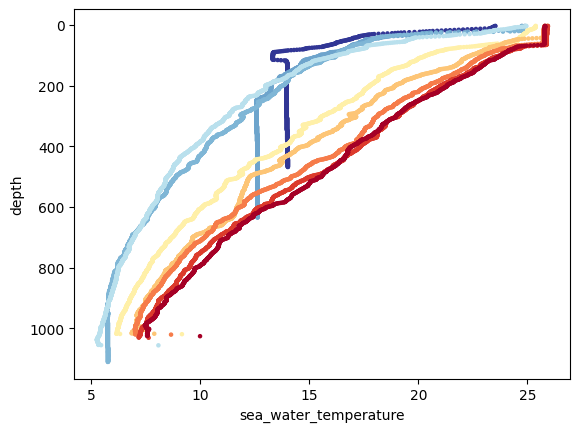

In [11]:
df[df['TEMP_quality_control'] == 1].sort_values('TIME').plot.scatter(x='TEMP', y='DEPTH', c='TIME', 
                                                                     xlabel=metadata['TEMP']['standard_name'],
                                                                     ylabel=metadata['DEPTH']['standard_name'],
                                                                     cmap='RdYlBu_r', marker='.', linestyle="None").invert_yaxis()

## Create a TIME and scalar/number filter

In [12]:
%%time
df = aodn_dataset.get_data(date_start='2024-01-31 10:14:00', date_end='2024-02-01 07:50:00',
                          scalar_filter = {'XBT_line': 'PX34'})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12616 entries, 0 to 12615
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   TIME                   12616 non-null  datetime64[ns]
 1   LATITUDE               12616 non-null  float64       
 2   LONGITUDE              12616 non-null  float64       
 3   DEPTH                  12616 non-null  float64       
 4   DEPTH_quality_control  12616 non-null  float32       
 5   TEMP                   12616 non-null  float64       
 6   TEMP_quality_control   12616 non-null  float32       
 7   imo_number             12616 non-null  int32         
 8   ship_name              12616 non-null  object        
 9   Callsign               12616 non-null  object        
 10  filename               12616 non-null  object        
 11  XBT_line               12616 non-null  object        
 12  timestamp              12616 non-null  int32         
 13  p

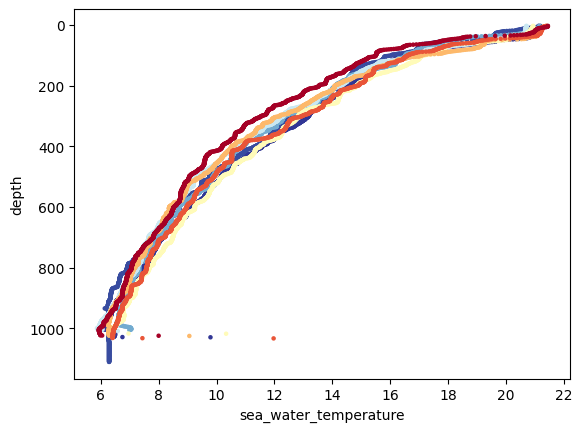

In [13]:
## Plotting only Good Quality data using QC flags
df[df['TEMP_quality_control'] == 1].sort_values('TIME').plot.scatter(x='TEMP', y='DEPTH', c='TIME', cmap='RdYlBu_r',
                                                                     xlabel=metadata['TEMP']['standard_name'],
                                                                     ylabel=metadata['DEPTH']['standard_name'],
                                                                     marker='.', linestyle="None").invert_yaxis()